In [1]:
import os, logging, multiprocessing
from tqdm.notebook import tqdm
from IPython.display import Image, display

import numpy as np
import matplotlib.pyplot as plt

from ase import Atoms
from ase.visualize import view
from ase.io import read, write # read and write structures
from ase.calculators.calculator import Calculator, all_changes, all_properties

# import functions to run this tutorial
from myfunctions import train_mace                # train MACE model
from myfunctions import eval_mace                 # evaluate MACE model
from myfunctions import extxyz2energy             # extract energy from extxyz file
from myfunctions import extxyz2array              # extract forces from extxyz file
from myfunctions import run_qbc                   # run Query by Committee
from myfunctions import run_single_aims_structure # call FHI-aims

/Users/krystofbrezina/Software/miniconda3/lib/python3.11/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


In [2]:
plt.style.use('notebook.mplstyle')

In [3]:
# MACE committee
n_init_train = 20
n_test = 50  
n_committee = 4
parallel = False

# QbC
n_iter_qbc = 10
n_add_iter = 10    

# random number set up - is it necessary to have this expliticly here?
#np.random.seed(0) 
seeds = np.random.randint(0, 2**32 - 1, size=n_committee, dtype=np.uint32)

## Part III: Eigen inference

In [4]:
forces = np.array([extxyz2array(f'../ipi-examples/eigen-inference/ipi.mace_force_{n:d}.extxyz', 
                                keyword='forces_component_raw') 
                   for n in tqdm(range(n_committee))])

dforces = forces - forces.mean(axis=0)[None, ...]
disagreement_atomic = np.sqrt( ( (dforces**2).sum(axis=3) ).mean(axis=0) )
disagreement = disagreement_atomic.mean(axis=1)

  0%|          | 0/4 [00:00<?, ?it/s]

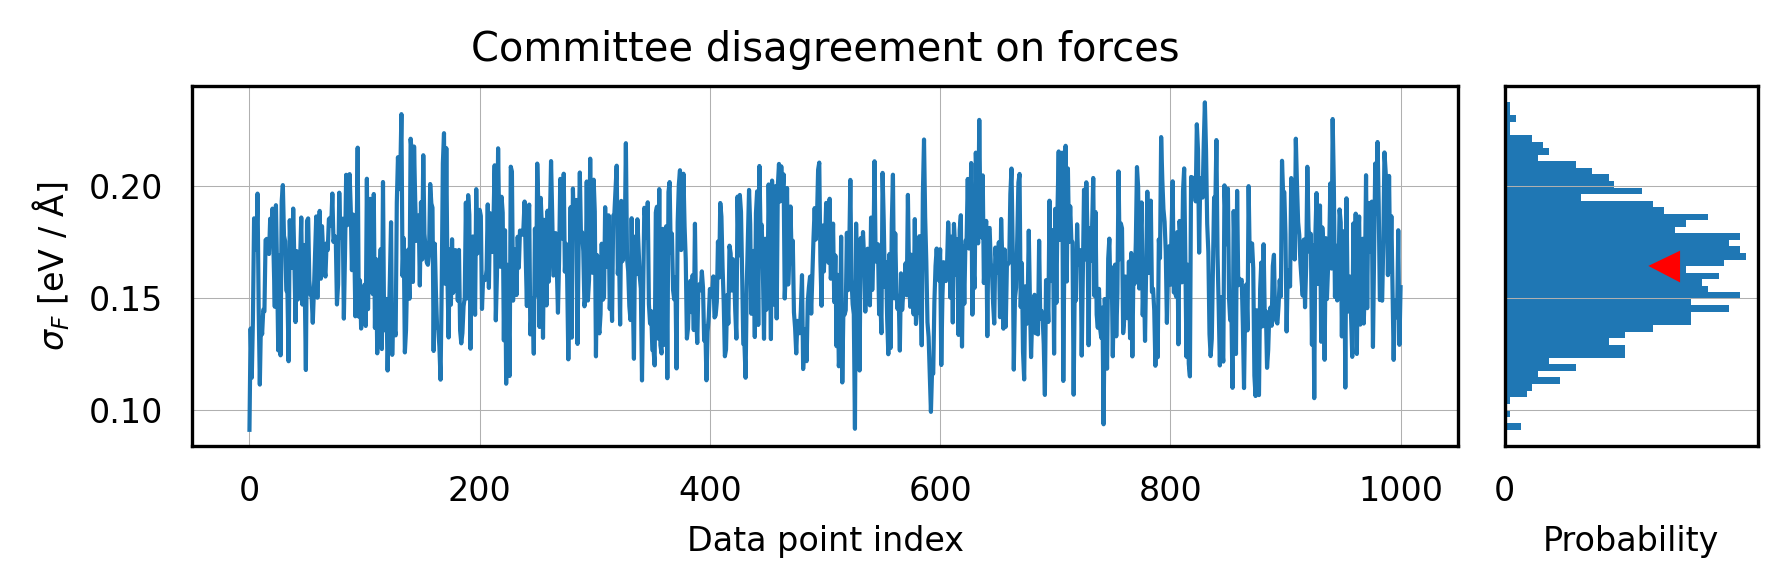

In [5]:
dt = 0.5e-3 # ps
stride = 20 # steps

fig, ax = plt.subplots(ncols=2, nrows=1, sharey=True, gridspec_kw=dict(width_ratios=[1, 0.2]))
ax[0].plot(disagreement)
ax[0].set_ylabel(r'$\sigma_F$ [eV / $\mathrm{\AA}$]')
ax[0].set_xlabel('Data point index')
ax[0].grid(True)
ax[0].set_title('Committee disagreement on forces')

ax[1].hist(disagreement, bins=50, orientation='horizontal', density=True)
ax[1].plot(10, disagreement.mean(), '<', c='r')
ax[1].set_xlabel('Probability')
ax[1].set_xticks([0])

plt.tight_layout();

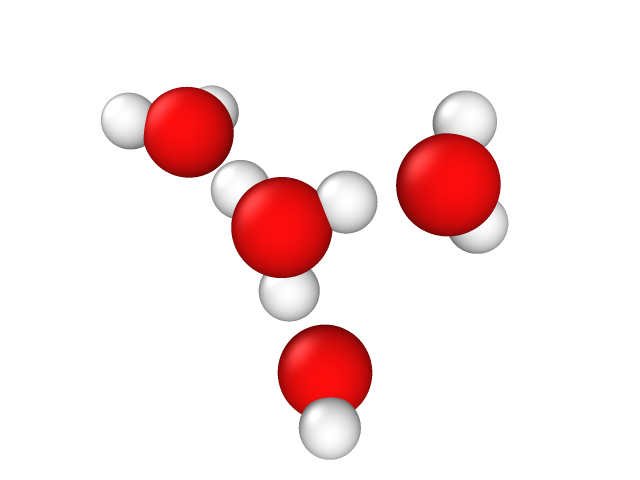

In [6]:
display(Image(filename='../initial-datasets/eigen/eigen.png'))

In [7]:
md_folder = "md"
init_train_folder = "init-train"
qbc_folder = "qbc-work" # if you modify this, add the new folder to .gitignore
Eigen_qbc_folder = "eigen-qbc-work"

In [8]:
# Run Q
os.makedirs(Eigen_qbc_folder, exist_ok=True)
os.makedirs(f'{Eigen_qbc_folder}/config', exist_ok=True)
# seeds = np.random.randint(0, 2**32 - 1, size=n_committee, dtype=np.uint32)
for i in range(n_committee):
    filename = f"{Eigen_qbc_folder}/config/config.{i}.yml"
    name = f"mace.com={i}"
    
    config_text = f"""
# You can modify the following parameters
num_channels: 16
max_L: 1            # take it larger but not smaller
max_ell: 2          # take it larger but not smaller
correlation: 2      # take it larger but not smaller
num_interactions: 2 # take it larger but not smaller

# ... but you can also modify these ones
r_max: 4.0
batch_size: 4
max_num_epochs: 10000 # this is basically early stopping
patience: 10       # we are a bit in a rush

# But please, do not modify these parameters!
model: "MACE"
name: "{name}"

model_dir      : "{Eigen_qbc_folder}/models"
log_dir        : "{Eigen_qbc_folder}/log"
checkpoints_dir: "{Eigen_qbc_folder}/checkpoints"
results_dir    : "{Eigen_qbc_folder}/results"

train_file: "{Eigen_qbc_folder}/train-iter.extxyz"
# test_file : "{init_train_folder}/structures/test.extxyz"
energy_key: "REF_energy"
forces_key: "REF_forces"
energy_weight: 1
forces_weight: 100



E0s: 
  1: -13.7487804074635
  8: -2045.41865185226
device: cpu
swa: false
seed: {seeds[i]}
restart_latest: True
distributed: False

"""

    with open(filename, "w") as f:
        f.write(config_text)

    print(f"Wrote {filename}")

Wrote eigen-qbc-work/config/config.0.yml
Wrote eigen-qbc-work/config/config.1.yml
Wrote eigen-qbc-work/config/config.2.yml
Wrote eigen-qbc-work/config/config.3.yml


In [9]:
_shared_logger = None  # Global singleton

def get_shared_logger(log_path='fhi_aims_calculator.log'):
    global _shared_logger
    if _shared_logger is None:
        logger = logging.getLogger("FHIaimsLogger")
        logger.setLevel(logging.INFO)
        logger.propagate = False  # Avoid duplicate output if root logger is also configured

        # Create handler only once
        handler = logging.FileHandler(log_path, mode='a')
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
        handler.setFormatter(formatter)
        logger.addHandler(handler)

        _shared_logger = logger
    return _shared_logger
    
class FHIaimsCalculator(Calculator):
    implemented_properties = ['energy', 'free_energy', 'forces', 'stress']

    # Shared logger
    logger = get_shared_logger()

    def __init__(self, aims_command, control_file, directory='.', output_path="aims.out", **kwargs):
        super().__init__(**kwargs)
        self.aims_command = aims_command
        self.control_file = control_file
        self.directory = directory
        self.output_path = output_path

    def calculate(self, atoms: Atoms = None, properties=all_properties, system_changes=all_changes):
        super().calculate(atoms, properties, system_changes)
        os.makedirs(self.directory, exist_ok=True)

        # Paths
        geom_path = os.path.join(self.directory, 'geometry.in')
        control_path = os.path.join(self.directory, 'control.in')
        output_path = os.path.join(self.directory, self.output_path)

        # RUN = False
        # if os.path.exists(output_path):
        #     try:
        #         output_atoms = read(output_path, format="aims-output")
        #         if not np.allclose(output_atoms.get_positions(), atoms.get_positions()) \
        #                 or not np.allclose(output_atoms.get_cell().T, atoms.get_cell().T):
        #             RUN = True
        #     except Exception as e:
        #         # self.logger.warning(f"Failed to read {output_path}: {e}")
        #         RUN = True
        # else:
        #     RUN = True

        # if RUN:
        cmd = f"{self.aims_command} > {self.output_path} 2>/dev/null"
        self.logger.info(f"Running AIMS command: {cmd}")
        run_single_aims_structure(atoms, self.directory, cmd, self.control_file)

        # After run: check output
        if not os.path.exists(output_path) or os.path.getsize(output_path) == 0:
            self.logger.error(f"AIMS output not found or empty in {output_path}")
            raise RuntimeError(f"AIMS calculation failed in '{self.directory}'")

        try:
            output_atoms = read(output_path, format="aims-output")
        except Exception as e:
            self.logger.error(f"Failed to read AIMS output in {output_path}: {e}")
            raise RuntimeError(f"Failed to parse AIMS output: {e}")


        try:
            output_atoms = read(output_path, format="aims-output")
        except Exception as e:
            self.logger.error(f"Failed to parse output at {output_path}: {e}")
            raise e

        self.results = {
            "energy": output_atoms.get_potential_energy(),
            "free_energy": output_atoms.get_potential_energy(),
            "forces": output_atoms.get_forces(),
            "stress": np.zeros(6)
        }
        self.logger.info(f"Calculation completed in '{self.directory}'")


# FHI-aims executable
aims_path = "/Users/krystofbrezina/build/FHIaims/build/aims.250507.scalapack.mpi.x"
assert os.path.exists(aims_path), "executable not found"

# ase.Calculator factory
def calculator_factory(n:int,filepath:str):
    os.makedirs('eigen-qbc-work',exist_ok=True)
    os.makedirs('eigen-qbc-work/aims',exist_ok=True)
    directory = f'eigen-qbc-work/aims/run-{n}'
    os.makedirs(directory,exist_ok=True)
    calculator = FHIaimsCalculator(aims_command=f"mpirun -n 4 {aims_path}",
                               control_file="../aims/control.in",
                               directory=directory,
                               output_path="aims.out")
    return calculator

# # usage example
# atoms = read("../initial-datasets/eigen/eigen.xyz") # read the structure
# calculator = calculator_factory(0,None)             # create the calculator
# atoms.calc = calculator                             # assign the calculator
# atoms.get_potential_energy() # trigger              # call the calculator

In [11]:
# Attention: this function will not restart from a previously stopped run
run_qbc(
    init_train_folder="qbc-work/",
    init_train_file="qbc-work/structures/train-iter.n=9.extxyz",   # initial training dataset
    fn_candidates=f'../checkpoints/eigen-inference/train.extxyz',  # candidate structures
    test_dataset=None,                                             # test set
    n_iter=5,                                                      # number of QbC iterations
    config='eigen-qbc-work/config',                                # folder with config files
    ofolder='eigen-qbc-work',                                      # folder to save the QBC results
    n_add_iter=5,                                                  # number of structures to add in each iteration
    recalculate_selected=True,                                     # whether to recalculate the selected structures with DFT (part 2)
    calculator_factory=calculator_factory,
    parallel=False
);

Starting QbC.
Number of models: 4
Number of iterations: 5
Number of new candidates at each iteration: 5
Candidates file: ../checkpoints/eigen-inference/train.extxyz
Test file: None

	--------------------------------------------------------------------
	Start of QbC iteration 1/5

	Started at: 2025-06-12 12:07:09
	Predicting committee disagreement across the candidate pool.
	Picking 5 new highest-disagreement data points.
	Recalculating ab initio energies and forces for new data points.
	Ab initio calculations:   5/  5
	Time spent in ab initio calculations:   217.39 seconds
	Retraining committee.
	training duration:   67.62 seconds

	Results:
	               Disagreement (pool): 0.176457 eV
	           Disagreement (selected): 0.238648 eV
	                New training set size: 125
	               New candidate set size: 295
	Ended at:   2025-06-12 12:12:00
	Duration:   290.91 seconds

	--------------------------------------------------------------------
	Start of QbC iteration 2/5

	St